# TP05 : Supervised learning – System Design and Debugging

Student names:
- Dan Yvan Baumgartner
- Jan Huber

## Exercise 1 : Gradient descent using matrix calculation

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d

In [2]:
def hypothesis(theta,X):  #theta = 1xD, X = DxN, output 1xN
    return np.dot(theta,X)

def gradientDescent(X,y,learning_rate,num_epoch,verbose=False):
    N = X.shape[0]      # number of sample
    D = X.shape[1]      # number of dimensions
    theta = np.ones(D)  # init thetas to some values
    X_trans = X.transpose() # X_trans is DxN
    J_theta = np.zeros(num_epoch)

    for i in range(0,num_epoch):
        h = hypothesis(theta,X_trans)  #N dimension
        loss = h-y                     #N dimension
        gradient = X_trans.dot(loss) * (1.0/N)
        theta = theta - learning_rate * (1.0/N) * gradient
        
        h = hypothesis(theta,X_trans)
        J_theta[i] = 1/(2*len(X))*np.sum(np.square((h-y)))
    return theta, J_theta

### a) Analyse the code above. It relies on matrix calculation. What type of gradient descent does it implement ? Are you confident it is a correct implementation ?

This is the implementation of the batch gradient descent. However, it uses the following update method :

$\theta_{i}\leftarrow \theta_{i} - \alpha \dfrac{1}{N^2} \sum \limits_{n=1}^{N}(h_{\theta}(x_n)-y_n)x_{n,i}$

This formula differs from the one presented in the theory (the factor $\dfrac{1}{N^2}$), but the behavior isn't changed. It is equivalent to the regular batch gradient descent with a learning rate scaled down by a factor of $\dfrac{1}{N}$.

In [3]:
# Read the training data
dataset = 'lausanne-appart.xlsx'
df_train = pd.read_excel(dataset)
df_train = df_train.iloc[:, 0:3]

# Format the training data
x = df_train.iloc[:, [1, 0]].values
y = df_train.iloc[:, 2].values

### b) Plot the plane $h_\theta(x)=\theta_0+\theta_1 x_1+\theta_2 x_2$ on top of the 3d scatter plot.

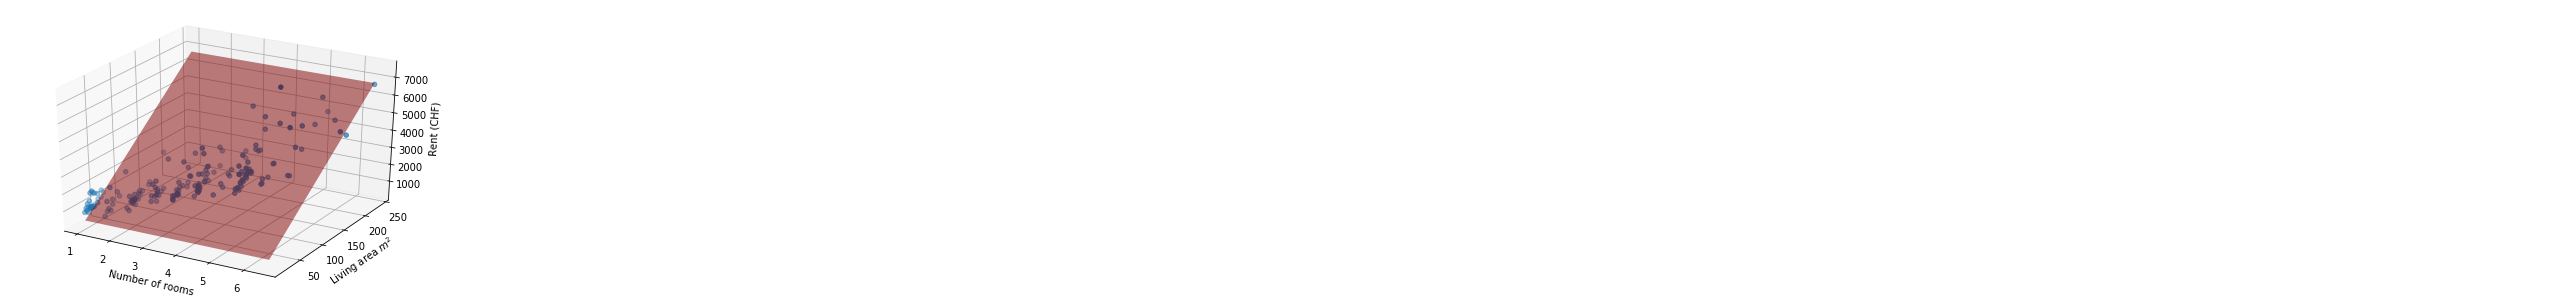

In [4]:
x0 = np.vstack(np.ones(len(x)))
X = np.append(x0, x, axis=1)

x0Unseen = np.array([np.min(x[:, 0]),np.max(x[:, 0])])
x1Unseen = np.array([np.min(x[:, 1]),np.max(x[:, 1])])

alpha = 0.0001
theta,J_theta = gradientDescent(X, y, alpha, 1000)

zHat = np.zeros((2,2))
for x1u in range(len(x1Unseen)):
    for x0u in range(len(x0Unseen)):
        zHat[x1u][x0u] = hypothesis(theta,[1,x0Unseen[x0u],x1Unseen[x1u]])


fig = plt.figure()
ax = Axes3D(fig)
xx, yy = np.meshgrid(x0Unseen,x1Unseen)

ax.scatter(x[:, 0], x[:, 1], y)
ax.plot_surface(xx, yy, zHat,alpha=0.5,color='r')
ax.set_xlabel('Number of rooms')
ax.set_zlabel('Rent (CHF)')
ax.set_ylabel('Living area $m^2$')
plt.show()

In [5]:
def zero_norm(x):
    N = x.shape[0]      # number of sample
    D = x.shape[1]      # number of dimensions

    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    xZeroNorm = np.zeros((N, D))

    for d in range(D):
        for n in range(N):
            xZeroNorm[n, d] = (x[n, d] - mean[d])/std[d]

    return xZeroNorm

xNorm = zero_norm(x)
XNorm = np.append(x0, xNorm, axis=1)
alpha = 1.5
thetaNorm,J_theta_Norm = gradientDescent(XNorm, y, alpha, 1000)


fig = plt.figure()
ax = Axes3D(fig)

x0Unseen = np.array([np.min(xNorm[:, 0]),np.max(xNorm[:, 0])])
x1Unseen = np.array([np.min(xNorm[:, 1]),np.max(xNorm[:, 1])])
zHatNorm = np.zeros((2,2))
for x1u in range(len(x1Unseen)):
    for x0u in range(len(x0Unseen)):
        zHatNorm[x1u][x0u] = hypothesis(thetaNorm,[1,x0Unseen[x0u],x1Unseen[x1u]])

xx, yy = np.meshgrid(x0Unseen,x1Unseen)

ax.scatter(xNorm[:, 0], xNorm[:, 1], y)
ax.plot_surface(xx, yy, zHatNorm,alpha=0.5, color='r')
ax.set_xlabel('Number of rooms')
ax.set_zlabel('Rent')
ax.set_ylabel('Living area')
plt.show()

### c) Implement the zero-norm normalisation and apply it to the number of rooms and living area. Does it help for the convergence ?

The zero-norm normalisation affected the intrinsic learning rate. Therefore, the $\alpha$ parameter could be increased to $1.5$ to be able to converge within the same number of iterations. After reaching convergence, both models had the same overall cost values.

In conclusion, the normalisation didn't help for the convergence.

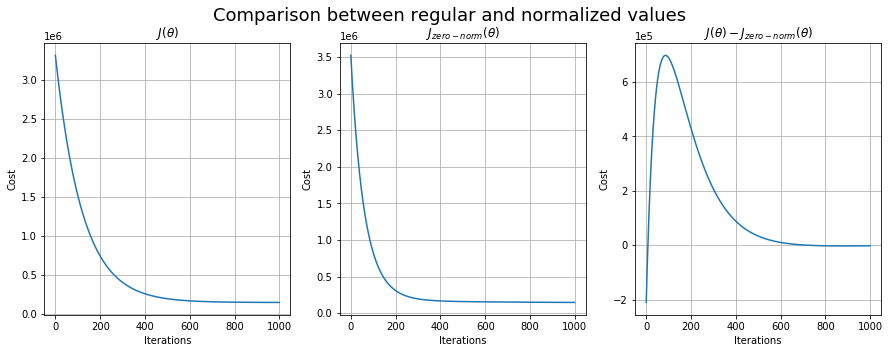

In [6]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Comparison between regular and normalized values', fontsize=18)


plt.subplot(1, 3, 1)
plt.title('$J(\\theta)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(range(len(J_theta)),J_theta)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()


plt.subplot(1, 3, 2)
plt.title('$J_{zero-norm}(\\theta)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(range(len(J_theta_Norm)),J_theta_Norm)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()


plt.subplot(1, 3, 3)
plt.title('$J(\\theta) - J_{zero-norm}(\\theta)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(range(len(J_theta_Norm)),J_theta-J_theta_Norm)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()

## Exercice 2 Linear regression optimisation

### a) Read the data in separate variables for the training and cross-validation sets

In [7]:
dataset = 'overfitting.xlsx'
df_train = pd.read_excel(dataset, sheet_name=0) # Read the training set
df_cv = pd.read_excel(dataset, sheet_name=1) # Read the cross validation set

xTrain = df_train.iloc[:, 0].values
yTrain = df_train.iloc[:, 1].values

xCv = df_cv.iloc[:, 0].values
yCv = df_cv.iloc[:, 1].values

x0Train = np.vstack(np.ones(len(xTrain)))
x0Cv = np.vstack(np.ones(len(xCv)))

XTrain = np.append(x0Train, xTrain.reshape((len(xTrain), 1)), axis=1)
XCv = np.append(x0Cv, xCv.reshape((len(xCv), 1)), axis=1)

xUnseen = np.linspace(np.min(xTrain),np.max(xTrain), 100)

### b) Define a cost function $J(\theta)$ that will allow you to compute the cost on the training and cross-validation sets

$J_{train}(\theta) = \dfrac{1}{2N_{train}} \sum \limits_{n=1}^{N_{train}} ( h_{\theta}(x^{train}_n) - y^{train}_n )^{2}$

$J_{cv}(\theta) = \dfrac{1}{2N_{cv}} \sum \limits_{n=1}^{N_{cv}} ( h_{\theta}(x^{cv}_n) - y^{cv}_n )^{2}$

In [8]:
def cost(x, y, h):
    N = len(x)     # number of sample

    J_theta = 1/(2*N) * np.sum(np.square(h(x) - y))

    return J_theta

### c) Perform the training for increasing orders $O = 1, \ldots , 7$

In [9]:
maxDeg = 7
maxDegRange = list(range(1, maxDeg+1))
J_theta_train = np.zeros(maxDeg)
J_theta_cv = np.zeros(maxDeg)
yHat = np.zeros( (maxDeg, len(xUnseen)) )

for i in range(maxDeg):
    theta = np.polyfit(xTrain, yTrain, deg=i+1)
    h = np.poly1d(theta)
    yHat[i] = h(xUnseen)
    J_theta_train[i] = cost(xTrain, yTrain, h)
    J_theta_cv[i] = cost(xCv, yCv, h)
    

### d) Plot the trained hypothesis

In [10]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Linear regression for different polynomial degrees', fontsize=18)


plt.subplot(1, 2, 1)
plt.scatter(xTrain, yTrain, color='xkcd:almost black')
for i in range(maxDeg):
    plt.plot(xUnseen, yHat[i])
plt.title('Hypothesis + scatter plot training set')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(maxDegRange)


plt.subplot(1, 2, 2)
plt.scatter(xCv, yCv, color='xkcd:almost black')
for i in range(maxDeg):
    plt.plot(xUnseen, yHat[i])
plt.title('Hypothesis + scatter plot CV set')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(maxDegRange)


plt.show()


### e) Plot the evolution of the costs $J_{train}(\theta)$ and $J_{cv}(\theta)$ as a function of the order $O$

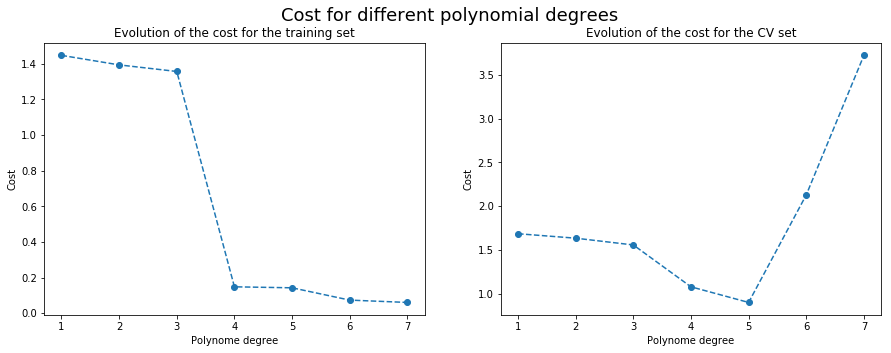

In [11]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Cost for different polynomial degrees', fontsize=18)


plt.subplot(1, 2, 1)
plt.plot(maxDegRange, J_theta_train, linestyle='--', marker='o')
plt.title('Evolution of the cost for the training set')
plt.xlabel('Polynome degree')
plt.ylabel('Cost')


plt.subplot(1, 2, 2)
plt.plot(maxDegRange, J_theta_cv, linestyle='--', marker='o')
plt.title('Evolution of the cost for the CV set')
plt.xlabel('Polynome degree')
plt.ylabel('Cost')


plt.show()

### f) What is the best model according to these costs?

The following graph shows that the model is underfitting for $1\leq O \leq 3$ because both $J_{train}$ and $J_{CV}$ have a high bias. For $4\leq O \leq 5$ the model is at its best performance, especially for $O=5$ because it minimizes both $J_{train}$ and $J_{CV}$ the most. Finally, the model is overfitting for $6\leq O \leq 7$ because $J_{train}\approx0$ while the gap between $J_{train}$ and $J_{CV}$ is at its greatest.

In short, the best model is using a 5th order polynomial : $O=5$.

In [12]:
plt.plot(maxDegRange, J_theta_train, linestyle='--', marker='o')
plt.plot(maxDegRange, J_theta_cv, linestyle='--', marker='s')
plt.title('Evolution of $J_{train}$ and $J_{CV}$')
plt.xlabel('Polynome degree O')
plt.ylabel('Cost')
plt.legend(['$J_{train}$', '$J_{CV}$'])